In [17]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature
import statsmodels.api as sm
from scipy import signal
import random
import matplotlib.gridspec as gridspec
from scipy.signal import detrend
import urllib.request
import scipy.stats as stats
import itertools
import matplotlib.patches as mpatches

### Functions

In [2]:
## Functions

def std_anom_spv(x):
    std_x = (x - x.mean(dim='time'))/x.std(dim='time')
    return std_x

def std_anom(x):
    std_x = (x - x.mean(dim='time'))/x.std(dim='time')
    return std_x 

def make_xarr(data,time):
    time_series = xr.DataArray(
    data,
    coords=[time],
    dims=["time"],
    name="time_array")
    return time_series

def find_80_percent_ellipse_values(data):
    mean_vector = data.mean()
    cov_matrix = np.cov(data.T)
    chi2_value = stats.chi2.ppf(0.80, df=5)  # 80% confidence level

    result_dict = {}
    for column in data.columns:
        mean = mean_vector[column]
        std_dev = np.sqrt(cov_matrix[data.columns.get_loc(column), data.columns.get_loc(column)])
        
        # Compute the lower and upper bounds
        lower_bound = mean - std_dev * np.sqrt(chi2_value/5)
        upper_bound = mean + std_dev * np.sqrt(chi2_value/5)
        
        result_dict[column] = {'mean': mean, 'lower_bound': lower_bound, 'upper_bound': upper_bound}
    
    return pd.DataFrame(result_dict).T


def regressor_EESC_GW(gw_ts):
    eesc_ts = pd.read_csv('/home/jmindlin/causal_EDJ/send_to_LIM/GW_EESC_polar_ozoneloss.csv')
    for i in range(len(eesc_ts[:8])):
        eesc_ts['EESC_polar'][i] = eesc_ts['EESC_polar'][8]
    df = pd.DataFrame({'EESC':eesc_ts['EESC_polar'][10:79] - eesc_ts['EESC_polar'][8],'GW':gw_ts})
    regressors_out = sm.add_constant(df.values)
    return regressors_out, df

def stand_detr(dato):
    anom = (dato - np.mean(dato))/np.std(dato)
    return signal.detrend(anom)

def filtro(dato):
    """Apply a rolling mean of 5 years and remov the NaNs resulting bigining and end"""
    signal = dato - dato.rolling(time=10, center=True).mean()
    signal_out = signal.dropna('time', how='all')
    return signal_out
                          
def stand(dato):
    anom = (dato - np.mean(dato))/np.std(dato)
    return anom

def replace_nans_with_zero(x):
    return np.where(np.isnan(x), random.random(), x)

def figure(target,predictors):
    fig = plt.figure()
    y = predictors.apply(stand_detr,axis=0).values
    for i in range(len(predictors.keys())):
        plt.plot(y[:,i])
    plt.plot(stand_detr(target))
    return fig

def jet_lat_strength(jet_data,lon1=-180,lon2=180):
    if np.max(jet_data.lon.values) > 300:
        ds = jet_data.assign_coords(lon=((jet_data.lon + 180) % 360) - 180)
        ds = ds.sortby("lon")
        jet_data = ds
    else:
        jet_data = jet_data
    jet_30_70 = jet_data.sel(lat=slice(-30,-70)).sel(lon=slice(lon1,lon2)).mean(dim='lon')
    lat = jet_30_70.lat
    jet_lat = (jet_30_70*lat).sum(dim='lat')/(jet_30_70).sum(dim='lat')
    strength = []
    for t,max_lat in zip(jet_data.time,jet_lat):
        strength.append(jet_data.sel(time=t).sel(lat=max_lat,method='nearest').sel(lon=slice(lon1,lon2)).mean(dim='lon'))
    jet_strength = np.array(strength)
    return np.array(jet_lat.values),jet_strength

def jet_lat_strength_model(jet_data,lon1=-180,lon2=180):
    if np.max(jet_data.lon.values) > 300:
        ds = jet_data.assign_coords(lon=((jet_data.lon + 180) % 360) - 180)
        ds = ds.sortby("lon")
        jet_data = ds
    else:
        jet_data = jet_data
    jet_30_70 = jet_data.sel(lat=slice(-70,-30)).sel(lon=slice(lon1,lon2)).mean(dim='lon')
    lat = jet_30_70.lat
    jet_lat = (jet_30_70*lat).sum(dim='lat')/(jet_30_70).sum(dim='lat')
    strength = []
    for t,max_lat in zip(jet_data.time,jet_lat):
        strength.append(jet_data.sel(time=t).sel(lat=max_lat,method='nearest').sel(lon=slice(lon1,lon2)).mean(dim='lon'))
    jet_strength = np.array(strength)
    return np.array(jet_lat.values),jet_strength

def seasonal_data(data,season='DJF'):
    # select DJF
    DA_DJF = data.sel(time = data.time.dt.season==season)

    # calculate mean per year
    DA_DJF = DA_DJF.groupby(DA_DJF.time.dt.year).mean("time")
    DA_DJF = DA_DJF.rename({'year':'time'})
    return DA_DJF

def seasonal_data_months(data, months):
    """
    Selects specified months from an xarray object and averages the data for those months within each year.
    
    Parameters:
    - data: xarray.DataArray or xarray.Dataset
        The input data to process. It should have a 'time' coordinate.
    - months: list of int
        The months to select for averaging (1 = January, 2 = February, ..., 12 = December).
    
    Returns:
    - xarray.DataArray or xarray.Dataset
        The averaged data for the selected months within each year, accounting for months that span across years.
    """
    # Ensure 'time' coordinate is in a format that supports .dt accessor
    if np.issubdtype(data['time'].dtype, np.datetime64):
        time_coord = data['time']
    else:
        time_coord = xr.cftime_range(start=data['time'][0].values, periods=data['time'].size, freq='M')
        data = data.assign_coords(time=time_coord)

    # Select the relevant months and keep track of the original years
    selected_months_data = data.sel(time=data['time'].dt.month.isin(months))

    # Create a new time coordinate for grouping
    new_years = selected_months_data['time'].dt.year.values.copy()

    # Shift the year for December, if necessary
    if 12 in months:
        dec_mask = selected_months_data['time'].dt.month == 12
        new_years[dec_mask] += 1  # Increment year for December

    # Assign the new year as a coordinate to the selected data
    selected_months_data = selected_months_data.assign_coords(new_year=("time", new_years))

    # Now group by the new year and calculate the mean
    averaged_data = selected_months_data.groupby("new_year").mean(dim="time")

    # Rename the new year dimension to 'time' for consistency
    averaged_data = averaged_data.rename({"new_year": "time"})

    return averaged_data


#Across models regression class
class spatial_MLR(object):
    def __init__(self):
        self.what_is_this = 'This performs a regression across models and plots everything'
    
    def regression_data(self,variable,regressors,regressor_names,dataset):
        """Define the regression target variable 
        this is here to be edited if some opperation is needed on the DataArray
        
        :param variable: DataArray
        :return: target variable for the regression  
        """
        self.dataset = dataset
        self.target = variable
        regressor_indices = regressors
        self.regression_y = sm.add_constant(regressors.values)
        self.regressors = regressors.values
        self.rd_num = len(regressor_names) 
        self.regressor_names = regressor_names

    #Regresion lineal
    def linear_regression(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        returns = [res.params[i] for i in range(self.rd_num)]
        return tuple(returns)

    def linear_regression_pvalues(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        returns = [res.pvalues[i] for i in range(self.rd_num)]
        return tuple(returns)
    
    def linear_regression_R2(self,x):
        y = self.regression_y
        res = sm.OLS(x,y).fit()
        return res.rsquared
    

    def perform_regression(self,path,var): 
        """ Performs regression over all gridpoints in a map and returns and saves DataFrames
        
        :param path: saving path
        :return: none
        """
        
        target_var = xr.apply_ufunc(replace_nans_with_zero, self.target)
        results = xr.apply_ufunc(self.linear_regression,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[] for i in range(self.rd_num)],
                                 vectorize=True,
                                 dask="parallelized")
        results_pvalues = xr.apply_ufunc(self.linear_regression_pvalues,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[] for i in range(self.rd_num)],
                                 vectorize=True,
                                 dask="parallelized")
        results_R2 = xr.apply_ufunc(self.linear_regression_R2,target_var,input_core_dims=[["time"]],
                                 output_core_dims=[[]],
                                 vectorize=True,
                                 dask="parallelized")
        
      
        for i in range(self.rd_num):
            if i == 0:
                regression_coefs = results[0].to_dataset(name='const')
            else:
                regression_coefs[self.regressor_names[i]] = results[i]
                
        print('This is regressor_coefs:',regression_coefs)
        if var == 'ua':
            regression_coefs = regression_coefs.rename({'ua':self.regressor_names[0]})
        elif var == 'sst':
            regression_coefs = regression_coefs.rename({'tos':self.regressor_names[0]})
        elif var == 'tas':
            regression_coefs = regression_coefs.rename({'tas':self.regressor_names[0]})
        elif var == 'pr':
            regression_coefs = regression_coefs.rename({'pr':self.regressor_names[0]})
        else:
            'done'
            #regression_coefs = regression_coefs.rename({var:self.regressor_names[0]})
        regression_coefs.to_netcdf(path+'/'+var+'/regression_coefficients_'+self.dataset+'.nc')
        
        for i in range(self.rd_num):
            if i == 0:
                regression_coefs_pvalues = results_pvalues[0].to_dataset(name='const')
            else:
                regression_coefs_pvalues[self.regressor_names[i]] = results_pvalues[i]        
        if var == 'ua':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'ua':self.regressor_names[0]})
        elif var == 'sst':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'tos':self.regressor_names[0]})
        elif var == 'tas':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'tas':self.regressor_names[0]})
        elif var == 'pr':
            regression_coefs_pvalues = regression_coefs_pvalues.rename({'pr':self.regressor_names[0]})
        else:
            'done'
            #regression_coefs_pvalues = regression_coefs_pvalues.rename({var:self.regressor_names[0]})
        regression_coefs_pvalues.to_netcdf(path+'/'+var+'/regression_coefficients_pvalues_'+self.dataset+'.nc')
        

        results_R2.to_netcdf(path+'/'+var+'/R2_'+self.dataset+'.nc')
                     
        
    def create_x(self,i,j,dato):
        """ For each gridpoint creates an array and standardizes it 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """    
        x = np.array([])
        for y in range(len(dato.time)):
            aux = dato.isel(time=y)
            x = np.append(x,aux[i-1,j-1].values)
        return stand(x)
     
    
    def open_regression_coef(self,path,var,dataset):
        """ Open regression coefficients and pvalues to plot
        :param path: saving path
        :return maps: list of list of coefficient maps
        :return maps_pval:  list of coefficient pvalues maps
        :return R2: map of fraction of variance
        """ 
        maps = []; maps_pval = []
        coef_maps = xr.open_dataset(path+'/'+var+'/regression_coefficients_'+dataset+'.nc')
        coef_pvalues = xr.open_dataset(path+'/'+var+'/regression_coefficients_pvalues_'+dataset+'.nc')
        maps = [coef_maps[variable] for variable in self.regressor_names]
        maps_pval = [coef_pvalues[variable] for variable in self.regressor_names]
        R2 = xr.open_dataset(path+'/'+var+'/R2_'+dataset+'.nc')
        return maps, maps_pval, R2    

    def open_lmg_coef(self,path,var):
        """ Open regression coefficients and pvalues to plot
        :param path: saving path
        :return maps: list of list of coefficient maps
        :return maps_pval:  list of coefficient pvalues maps
        :return R2: map of fraction of variance
        """ 
        maps = []; maps_pval = []
        coef_maps = xr.open_dataset(path+'/'+var+'/regression_coefficients_relative_importance.nc')
        coef_pvalues = xr.open_dataset(path+'/'+var+'/regression_coefficients_pvalues.nc')
        maps = [coef_maps[variable] for variable in self.regressor_names[1:]]
        maps_pval = [coef_pvalues[variable] for variable in self.regressor_names]
        R2 = xr.open_dataset(path+'/'+var+'/R2.nc')
        return maps, maps_pval, R2    
    
    def plot_regression_lmg_map(self,path,var,output_path):
        """ Plots figure with all of 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """
        maps, maps_pval, R2 = self.open_lmg_coef(path,var)
        cmapU850 = mpl.colors.ListedColormap(['darkblue','navy','steelblue','lightblue',
                                            'lightsteelblue','white','white','mistyrose',
                                            'lightcoral','indianred','brown','firebrick'])
        cmapU850.set_over('maroon')
        cmapU850.set_under('midnightblue')
        path_era = '/datos/ERA5/mon'
        u_ERA = xr.open_dataset(path_era+'/era5.mon.mean.nc')
        u_ERA = u_ERA.u.sel(lev=850).sel(time=slice('1979','2018'))
        u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

        fig_coef = plt.figure(figsize=(20, 16),dpi=100,constrained_layout=True)
        projection_stereo = ccrs.SouthPolarStereo(central_longitude=300)
        projection_plate = ccrs.PlateCarree(180)
        data_crs = ccrs.PlateCarree()
        for k in range(self.rd_num-1):
            lat = maps[k].lat
            lon = np.linspace(0,360,len(maps[k].lon))
            var_c, lon_c = add_cyclic_point(maps[k].values,lon)
            #SoutherHemisphere Stereographic
            if var == 'ua':
                ax = plt.subplot(3,3,k+1,projection=projection_stereo)
                ax.set_extent([0,359.9, -90, 0], crs=data_crs)
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)
                ax.set_boundary(circle, transform=ax.transAxes)
            elif var == 'sst':
                ax = plt.subplot(3,3,k+1,projection=projection_plate)
            else: 
                ax = plt.subplot(3,3,k+1,projection=projection_stereo)
            clevels = np.arange(0,40,2)
            im=ax.contourf(lon_c, lat, var_c*100,clevels,transform=data_crs,cmap='OrRd',extend='both')
            cnt=ax.contour(u_ERA.lon,u_ERA.lat, u_ERA.values,levels=[8],transform=data_crs,linewidths=1.2, colors='black', linestyles='-')
            plt.clabel(cnt,inline=True,fmt='%1.0f',fontsize=8)
            if maps_pval[k+1].min() < 0.05: 
                levels = [maps_pval[k+1].min(),0.05,maps_pval[k+1].max()]
                ax.contourf(maps_pval[k+1].lon, lat, maps_pval[k+1].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            elif maps_pval[k+1].min() < 0.10:
                levels = [maps_pval[k+1].min(),0.10,maps_pval[k+1].max()]
                ax.contourf(maps_pval[k+1].lon, lat, maps_pval[k+1].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            else:
                print('No significant values for ',self.regressor_names[k+1]) 
            plt.title(self.regressor_names[k+1],fontsize=18)
            ax.add_feature(cartopy.feature.COASTLINE,alpha=.5)
            ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
            ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
            ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())
        plt1_ax = plt.gca()
        left, bottom, width, height = plt1_ax.get_position().bounds
        if var == 'ua':
            colorbar_axes1 = fig_coef.add_axes([left+0.5, bottom, 0.01, height*2])
        elif var == 'sst':
            colorbar_axes1 = fig_coef.add_axes([left+0.3, bottom, 0.01, height*2])    
        else:
            colorbar_axes1 = fig_coef.add_axes([left+0.5, bottom, 0.01, height*2])
        cbar = fig_coef.colorbar(im, colorbar_axes1, orientation='vertical')
        cbar.set_label('relative importance',fontsize=14) #rotation = radianes
        cbar.ax.tick_params(axis='both',labelsize=14)
            
        plt.subplots_adjust(bottom=0.2, right=.95, top=0.8)
        if var == 'ua':
            plt.savefig(output_path+'/regression_coefficients_relative_importance_u850',bbox_inches='tight')
        elif var == 'sst':
            plt.savefig(output_path+'/regression_coefficients_relative_importance_sst',bbox_inches='tight')
        else:
            plt.savefig(output_path+'/regression_coefficients_relative_importance_XXX',bbox_inches='tight')   
        plt.clf

        return fig_coef


    def plot_regression_coef_map(self,path,var,output_path):
        """ Plots figure with all of 
        :param regressor_names: list with strings naming the independent variables
        :param path: saving path
        :return: none
        """
        maps, maps_pval, R2 = self.open_regression_coef(path,var,self.dataset)
        cmapU850 = mpl.colors.ListedColormap(['darkblue','navy','steelblue','lightblue',
                                            'lightsteelblue','white','white','mistyrose',
                                            'lightcoral','indianred','brown','firebrick'])
        cmapU850.set_over('maroon')
        cmapU850.set_under('midnightblue')
        u_ERA = xr.open_dataset('/home/jmindlin/causal_EDJ/ERA5/ua_ERA5.nc')
        u_ERA = u_ERA.u.sel(level=850).sel(time=slice('1979','2018'))
        u_ERA = u_ERA.rename({'longitude':'lon','latitude':'lat'})
        u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

        fig_coef = plt.figure(figsize=(20, 16),dpi=100,constrained_layout=True)
        projection_stereo = ccrs.SouthPolarStereo(central_longitude=300)
        projection_plate = ccrs.PlateCarree(180)
        data_crs = ccrs.PlateCarree()
        for k in range(self.rd_num):
            lat = maps[k].lat
            lon = np.linspace(0,360,len(maps[k].lon))
            var_c, lon_c = add_cyclic_point(maps[k].values,lon)
            #SoutherHemisphere Stereographic for winds
            if var == 'u':
                ax = plt.subplot(3,2,k+1,projection=projection_stereo)
                ax.set_extent([0,359.9, -90, 0], crs=data_crs)
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)
                ax.set_boundary(circle, transform=ax.transAxes)
            #Plate Carree map for SST
            elif var == 'sst':
                ax = plt.subplot(3,2,k+1,projection=projection_plate)
            else: 
                ax = plt.subplot(3,2,k+1,projection=projection_stereo)
            if k == 6:
                im0=ax.contourf(lon_c, lat, var_c,transform=data_crs,cmap='OrRd',extend='both')
            else:
                clevels = np.arange(-.6,.7,0.1)
                im=ax.contourf(lon_c, lat, var_c,clevels,transform=data_crs,cmap='RdBu_r',extend='both')
            cnt=ax.contour(u_ERA.lon,u_ERA.lat, u_ERA.values,levels=[8],transform=data_crs,linewidths=1.2, colors='black', linestyles='-')
            plt.clabel(cnt,inline=True,fmt='%1.0f',fontsize=8)
            if maps_pval[k].min() < 0.05: 
                levels = [maps_pval[k].min(),0.05,maps_pval[k].max()]
                ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            elif maps_pval[k].min() < 0.10:
                levels = [maps_pval[k].min(),0.10,maps_pval[k].max()]
                ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values,levels, transform=data_crs,levels=levels, hatches=["...", " "], alpha=0)
            else:
                print('No significant values for ',self.regressor_names[k]) 
            plt.title(self.regressor_names[k],fontsize=18)
            ax.add_feature(cartopy.feature.COASTLINE,alpha=.5)
            ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
            ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
            if var == 'ua':
                ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())
            elif var == 'sst':
                ax.set_extent([-60, 220, -80, 40], ccrs.PlateCarree(central_longitude=180))
            else: 
                ax.set_extent([-60, 220, -80, -25], ccrs.PlateCarree(central_longitude=180))
            
        plt1_ax = plt.gca()
        left, bottom, width, height = plt1_ax.get_position().bounds
        if var == 'ua':
            colorbar_axes1 = fig_coef.add_axes([left+0.28, bottom, 0.01, height*2])
            colorbar_axes2 = fig_coef.add_axes([left+0.36, bottom, 0.01, height*2])
        elif var == 'sst':
            colorbar_axes1 = fig_coef.add_axes([left+0.3, bottom, 0.01, height*3])
            colorbar_axes2 = fig_coef.add_axes([left+0.38, bottom, 0.01, height*3])
        else:
            colorbar_axes1 = fig_coef.add_axes([left+0.28, bottom, 0.01, height*2])
            colorbar_axes2 = fig_coef.add_axes([left+0.36, bottom, 0.01, height*2])
        cbar = fig_coef.colorbar(im, colorbar_axes1, orientation='vertical')
        cbar2 = fig_coef.colorbar(im, colorbar_axes2, orientation='vertical')
        if var == 'ua':
            cbar.set_label('m/s/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('m/s/std(rd)',fontsize=14) #rotation = radianes
        elif var == 'sst':
            cbar.set_label('K/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('K/std(rd)',fontsize=14) #rotation = radianes
        else:
            cbar.set_label('X/std(rd)',fontsize=14) #rotation = radianes
            cbar2.set_label('X/std(rd)',fontsize=14) #rotation = radianes
        cbar.ax.tick_params(axis='both',labelsize=14)
        cbar2.ax.tick_params(axis='both',labelsize=14)
            
        plt.subplots_adjust(bottom=0.2, right=.95, top=0.8)
        if var == 'ua':
            plt.savefig(output_path+'/regression_coefficients_u850',bbox_inches='tight')
        elif  var == 'sst':
            plt.savefig(output_path+'/regression_coefficients_sst',bbox_inches='tight')
        else:
            plt.savefig(output_path+'/regression_coefficients_unknown_var',bbox_inches='tight')
        
        plt.clf

        return fig_coef


def plot_regression_coef_map_MEM(maps, maps_pval, regressor_names, output_path):
    """Plots figure with regression coefficient maps with two distinct colorbars.
    :param regressor_names: list with strings naming the independent variables
    :param path: saving path
    :return: figure
    """

    # Custom colormap
    cmapU850 = mpl.colors.ListedColormap(['darkblue', 'navy', 'steelblue', 'lightblue',
                                'lightsteelblue', 'white', 'white', 'mistyrose',
                                'lightcoral', 'indianred', 'brown', 'firebrick'])
    cmapU850.set_over('maroon')
    cmapU850.set_under('midnightblue')

    # Load data for contours
    ua_era5 = xr.open_dataset('/home/jmindlin/causal_EDJ/ERA5/ua_ERA5.nc')
    ua_era5 = ua_era5.rename({'latitude': 'lat', 'longitude': 'lon'})
    ua_era5_850 = ua_era5.sel(level=850)
    u_ERA = ua_era5_850.u.sel(time=slice('1979', '2018'))
    u_ERA = u_ERA.groupby('time.season').mean(dim='time').sel(season='DJF')

    # Create figure and subplots with adjusted size
    fig_coef, axs = plt.subplots(2, 3, figsize=(24, 15), dpi=100,
                                subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=300)})
    plt.subplots_adjust(bottom=0.1, right=0.85, top=0.85, hspace=0.1, wspace=0.25)

    data_crs = ccrs.PlateCarree()

    # Loop over the subplots
    for k, ax in enumerate(axs.flat):
        if k >= len(maps):  # Stop if we have more subplots than data
            break
        
        lat = maps[k].lat
        lon = np.linspace(0, 360, len(maps[k].lon))
        var_c, lon_c = add_cyclic_point(maps[k].values, lon)

        ax.set_extent([0, 359.9, -90, 0], crs=data_crs)
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

        # Use different color scales for the first and other subplots
        if k == 0:
            clevels = np.arange(-11, 12, 1)
            # Contour plot
            im0 = ax.contourf(maps[k].lon, maps[k].lat, maps[k].values, clevels, transform=data_crs, cmap=cmapU850, extend='both')
        else:
            clevels = np.arange(-1, 1.1, 0.1)
            # Contour plot
            try:
                im = ax.contourf(maps[k].lon, maps[k].lat, maps[k].values, clevels, transform=data_crs, cmap=cmapU850, extend='both')
            except TypeError:
                print(maps[k])

        # Overlay contour lines for u_ERA
        cnt = ax.contour(u_ERA.lon, u_ERA.lat, u_ERA.values, levels=[8], transform=data_crs,
                        linewidths=1.2, colors='black', linestyles='-')
        ax.clabel(cnt, inline=True, fmt='%1.0f', fontsize=8)

        # Check for significant p-values and hatch regions
        if maps_pval[k].min() < 0.05:
            levels = [maps_pval[k].min(), 0.05, maps_pval[k].max()]
            ax.contourf(maps_pval[k].lon, lat, maps_pval[k].values, levels=levels,
                        transform=data_crs, hatches=["...", " "], alpha=0)
        
        # Plot title
        ax.set_title(regressor_names[k], fontsize=18)
        
        # Add coastlines and borders
        ax.add_feature(cartopy.feature.COASTLINE, alpha=.5)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
        ax.gridlines(crs=data_crs, linewidth=0.3, linestyle='-')
        ax.set_extent([-180, 180, -90, -25], ccrs.PlateCarree())

    # Create two colorbars outside the grid of subplots

    # Colorbar for the first subplot
    cbar_ax_1 = fig_coef.add_axes([0.87, 0.55, 0.02, 0.25])  # Manually specify position
    cbar_1 = fig_coef.colorbar(im0, cax=cbar_ax_1, orientation='vertical', ticks=np.arange(-11, 12, 1))
    cbar_1.set_label(r'm s$^{-1}$ $\sigma_{RD}^{-1}$', fontsize=14)
    cbar_1.ax.tick_params(axis='both', labelsize=12)

    # Add "panel a" text above the first colorbar
    plt.text(0.87, 0.82, 'panel a', fontsize=14, transform=fig_coef.transFigure, ha='center')

    # Colorbar for the remaining subplots
    cbar_ax_2 = fig_coef.add_axes([0.87, 0.18, 0.02, 0.25])  # Manually specify position
    cbar_2 = fig_coef.colorbar(im, cax=cbar_ax_2, orientation='vertical', ticks=np.arange(-1, 1.1, 0.1))
    cbar_2.set_label(r'm s$^{-1}$ $\sigma_{RD}^{-1}$', fontsize=14)
    cbar_2.ax.tick_params(axis='both', labelsize=12)

    # Add "panels b-f" text above the second colorbar
    plt.text(0.87, 0.45, 'panels b-f', fontsize=14, transform=fig_coef.transFigure, ha='center')

    plt.savefig(output_path, bbox_inches='tight')
    plt.clf()

    return fig_coef



def detrend_timeseries(da):
    """
    Remove the linear trend from an xarray DataArray.

    Parameters:
    - da: xarray.DataArray
        The input time series to detrend.

    Returns:
    - detrended_da: xarray.DataArray
        The detrended time series.
    """
    # Check if the input is a DataArray
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray DataArray")

    # Ensure that there is a 'time' coordinate
    if 'time' not in da.coords:
        raise ValueError("DataArray must have a 'time' coordinate")

    # Detrend the data along the time axis
    detrended_data = detrend(da, axis=0)

    # Return as a new DataArray, preserving the original coordinates
    detrended_da = xr.DataArray(detrended_data, dims=da.dims, coords=da.coords)
    
    return detrended_da



def multiple_linear_regression(target, predictors_dict):
    """
    Perform a multiple linear regression on a target time series using a dictionary of predictor time series.

    Parameters:
    - target: xarray.DataArray
        The target time series to predict.
    - predictors_dict: dict
        A dictionary where keys are predictor names and values are xarray.DataArray objects representing predictor time series.

    Returns:
    - results: statsmodels.regression.linear_model.RegressionResultsWrapper
        The results of the regression, including coefficients, p-values, etc.
    """
    # Check if input is a DataArray
    if not isinstance(target, xr.DataArray):
        raise TypeError("Target must be an xarray DataArray")
    
    # Ensure that there is a 'time' coordinate
    if 'time' not in target.coords:
        raise ValueError("Target DataArray must have a 'time' coordinate")

    # Convert the target and predictors to a pandas DataFrame
    df = pd.DataFrame({name: da.to_series() for name, da in predictors_dict.items()})
    
    # Ensure the target time series is aligned with predictors
    df['target'] = target.to_series()
    
    # Drop any rows with NaN values
    df.dropna(inplace=True)

    # Separate the predictors and the target
    X = df.drop(columns='target')
    y = df['target']

    # Add a constant (intercept) to the predictors
    X = sm.add_constant(X)

    # Perform the OLS regression
    model = sm.OLS(y, X)
    results = model.fit()

    return results


def standardize_data(da):
    """
    Standardize an xarray DataArray by subtracting the mean and dividing by the standard deviation.
    
    Parameters:
    da (xarray.DataArray or xarray.Dataset): Input data to standardize.
    
    Returns:
    xarray.DataArray or xarray.Dataset: Standardized data.
    """
    mean = da.mean(dim='time')
    std_dev = da.std(dim='time')
    
    standardized_da = (da - mean) / std_dev
    return standardized_da


class JetAnalysis:
    def __init__(self, jet_data, covariates_dict, lon1=140, lon2=295):
        """
        Initialize the class with the jet data and a dictionary of covariates.
        
        Parameters:
        - jet_data: xarray.DataArray
            The jet data with dimensions lat, lon, and time.
        - covariates_dict: dict
            Dictionary of covariates, where each key is a predictor name and each value is an xarray.DataArray.
        - lon1: int
            The starting longitude for the analysis (default is 140).
        - lon2: int
            The ending longitude for the analysis (default is 295).
        """
        self.jet_data = jet_data
        self.covariates_dict = covariates_dict
        self.lon1 = lon1
        self.lon2 = lon2
        self.jet_lat = None
        self.jet_strength = None
        self.regression_results = None
    
    def jet_lat_strength(self):
        """
        Calculate the jet latitude and jet strength from the input jet data.
        
        Returns:
        - jet_lat: np.array
            Array of calculated jet latitudes over time.
        - jet_strength: np.array
            Array of calculated jet strengths over time.
        """
        jet_30_70 = self.jet_data.sel(lat=slice(-70, -30)).sel(lon=slice(self.lon1, self.lon2)).mean(dim='lon')
        lat = jet_30_70.lat
        jet_lat = (jet_30_70 * lat).sum(dim='lat') / jet_30_70.sum(dim='lat')
        
        strength = []
        for t, max_lat in zip(self.jet_data.time, jet_lat):
            strength.append(self.jet_data.sel(time=t).sel(lat=max_lat, method='nearest').sel(lon=slice(self.lon1, self.lon2)).mean(dim='lon'))
        jet_strength = np.array(strength)
        
        # Store the results as class attributes
        self.jet_lat = np.array(jet_lat.values)
        self.jet_strength = jet_strength
        
        return self.jet_lat, self.jet_strength
    
    def standardize_data(self, da):
        """
        Standardize an xarray DataArray by subtracting the mean and dividing by the standard deviation.
        
        Parameters:
        - da: xarray.DataArray
            Input data to standardize.
        
        Returns:
        - standardized_da: xarray.DataArray
            Standardized data.
        """
        mean = da.mean(dim='time')
        std_dev = da.std(dim='time')
        standardized_da = (da - mean) / std_dev
        return standardized_da
    
    def multiple_linear_regression(self, target, predictors_dict):
        """
        Perform multiple linear regression on a target time series using a dictionary of predictors.
        
        Parameters:
        - target: xarray.DataArray
            The target time series to predict.
        - predictors_dict: dict
            A dictionary where keys are predictor names and values are xarray.DataArray objects representing predictor time series.
        
        Returns:
        - results: statsmodels.regression.linear_model.RegressionResultsWrapper
            The results of the regression, including coefficients, p-values, etc.
        """
        # Convert the target and predictors to a pandas DataFrame
        df = pd.DataFrame({name: da.to_series() for name, da in predictors_dict.items()})
        
        # Ensure the target time series is aligned with predictors
        df['target'] = target.to_series()
        
        # Drop any rows with NaN values
        df.dropna(inplace=True)

        # Separate the predictors and the target
        X = df.drop(columns='target')
        y = df['target']

        # Add a constant (intercept) to the predictors
        X = sm.add_constant(X)

        # Perform the OLS regression
        model = sm.OLS(y, X)
        results = model.fit()

        return results

    def analyze(self):
        """
        Perform the full analysis: calculate metrics, standardize data, perform regression, and save results.
        
        Returns:
        - results_dict: dict
            A dictionary containing the regression coefficients, p-values, and summary.
        """
        # Step 1: Calculate the jet latitude and strength
        jet_lat, jet_strength = self.jet_lat_strength()

        # Step 2: Standardize the data
        standardized_jet_lat = self.standardize_data(xr.DataArray(jet_lat, dims=['time'], coords={'time': self.jet_data.time}))
        standardized_jet_strength = self.standardize_data(xr.DataArray(jet_strength, dims=['time'], coords={'time': self.jet_data.time}))

        # Standardize the predictors
        standardized_predictors = {name: self.standardize_data(da) for name, da in self.covariates_dict.items()}

        # Step 3: Perform multiple linear regression on both metrics
        lat_results = self.multiple_linear_regression(standardized_jet_lat, standardized_predictors)
        strength_results = self.multiple_linear_regression(standardized_jet_strength, standardized_predictors)

        # Save the regression results
        self.regression_results = {
            'jet_lat_regression': lat_results,
            'jet_strength_regression': strength_results
        }

        # Step 4: Compile the results into a dictionary
        results_dict = {
            'jet_lat_coefficients': lat_results.params.to_dict(),
            'jet_lat_pvalues': lat_results.pvalues.to_dict(),
            'jet_lat_summary': lat_results.summary().as_text(),
            'jet_strength_coefficients': strength_results.params.to_dict(),
            'jet_strength_pvalues': strength_results.pvalues.to_dict(),
            'jet_strength_summary': strength_results.summary().as_text()
        }

        return results_dict

def std_anom(x):
    return (x - np.mean(x))/np.std(x)



# Define the linear regression function
def linear_regression(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    return slope, intercept


### Data

In [3]:
path = '/Users/jumindlin/Desktop/EDJ_data_code'

In [13]:
### Import ERA5 data

ua_era5 = xr.open_dataset(path+'/ERA5/ua_ERA5.nc')
ua_era5 = ua_era5.rename({'latitude':'lat','longitude':'lon'})
ua_era5_50 = ua_era5.sel(level=50)
ua_era5_850 = ua_era5.sel(level=850)
ta_era5 = xr.open_dataset(path+'/ERA5/ta_ERA5.nc')
ta_era5 = ta_era5.rename({'latitude':'lat','longitude':'lon'})

### Import NCEP data

ua_ncep = xr.open_dataset(path+'/NCEP/uwnd.mon.mean.nc')
ua_ncep_50 = ua_ncep.sel(level=50)
ua_ncep_850 = ua_ncep.sel(level=850)
ta_ncep = xr.open_dataset(path+'/NCEP/air.mon.mean.nc')

del ua_era5 #, ua_ncep

### Import JRA55 data

ua_jra55_50 = [xr.open_dataset(path+'/JRA55/ua/anl_mdl.033_ugrd.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin756630_50hPa.nc') for year in np.arange(1958,2024,1)]
ua_jra55_50_concat = xr.concat(ua_jra55_50,dim='initial_time0_hours')
ua_jra55_50_concat = ua_jra55_50_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon'})

ua_jra55_850 = [xr.open_dataset(path+'/JRA55/ua/anl_mdl.033_ugrd.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin756630_847hPa.nc') for year in np.arange(1958,2024,1)]
ua_jra55_850_concat = xr.concat(ua_jra55_850,dim='initial_time0_hours')
ua_jra55_850_concat = ua_jra55_850_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon'})

# ta_jra55 = [xr.open_dataset(path+'/JRA55/ta/anl_mdl.011_tmp.reg_tl319.'+str(year)+'01_'+str(year)+'12.mindlin754486.nc') for year in np.arange(1958,2024,1)]
# ta_jra55_concat = xr.concat(ta_jra55,dim='initial_time0_hours')
# ta_jra55_concat = ta_jra55_concat.rename({'initial_time0_hours':'time','g4_lat_2':'lat','g4_lon_3':'lon','lv_HYBL1':'lev'})


# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2024-12-01', freq='MS')
temperature_data = xr.DataArray(
    data_array, 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)

tas_DJF = seasonal_data_months(temperature_data.sel(time=slice('1950','2023')),[12,1,2])

u_1979_2019 = xr.open_dataset(path+'/send_to_LIM/ERA5/era5.mon.mean_T42.nc').u.sel(lev=50).drop_vars('lev')
u_1950_1978 = xr.open_dataset(path+'/send_to_LIM/ERA5/ERA5_monthly_u_wind_n36_rename_regrid.nc').u.sel(plev=5000).drop_vars('plev')
u_1950_2019 = xr.concat([u_1950_1978,u_1979_2019],'time')
spv_era5_OND = seasonal_data_months(u_1950_2019,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2019'))
spv_era5_1950_2019_OND = spv_era5_OND
CLIM_spv_era5 = spv_era5_1950_2019_OND.sel(time=slice('1950','2019')).mean(dim='time')

spv_ncep_OND = seasonal_data_months(ua_ncep_50,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
spv_ncep_1950_2023_OND = spv_ncep_OND
CLIM_spv_ncep = spv_ncep_1950_2023_OND.sel(time=slice('1950','2023')).mean(dim='time')

# spv_jra55_OND = seasonal_data_months(ua_jra55_50_concat,[10,11,12]).sel(lat=slice(-50,-60)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
# spv_jra55_1950_2023_OND = spv_jra55_OND
# CLIM_spv_jra55 = spv_jra55_1950_2023_OND.sel(time=slice('1950','2023')).mean(dim='time')


### Extend ERA5 SPV 2019-2023 with NCEP data
spv_era5_1950_2023_OND = xr.concat([spv_era5_1950_2019_OND,spv_ncep_1950_2023_OND.uwnd.sel(time=slice('2020','2023'))],dim='time')
stratospheric_polar_vortex_rean = []
stratospheric_polar_vortex_rean.append(spv_era5_1950_2023_OND)
# stratospheric_polar_vortex_rean.append(spv_ncep_1950_2023_OND)
# stratospheric_polar_vortex_rean.append(spv_jra55_1950_2023_OND)

tropical_warming = []
tw_era5_DJF = seasonal_data_months(ta_era5,[12,1,2]).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
tw_era5_1950_2023_DJF = tw_era5_DJF
tropical_warming.append(tw_era5_DJF)
CLIM_tw_era5 = tw_era5_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

tw_ncep_DJF = seasonal_data_months(ta_ncep,[12,1,2]).sel(level=250).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023')) + 273.15
tw_ncep_1950_2023_DJF = tw_ncep_DJF
tropical_warming.append(tw_ncep_DJF)
CLIM_tw_ncep = tw_ncep_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

# tw_jra55_DJF = seasonal_data_months(ta_jra55_concat,[12,1,2]).sel(lev=29).sel(lat=slice(15,-15)).mean(dim='lat').mean(dim='lon').sel(time=slice('1950','2023'))
# tw_jra55_1950_2023_DJF = tw_jra55_DJF
# tropical_warming.append(tw_jra55_DJF)
# CLIM_tw_jra55 = tw_jra55_1950_2023_DJF.sel(time=slice('1950','2023')).mean(dim='time')

eesc_ts = pd.read_csv(path+'/send_to_LIM/GW_EESC_polar_ozoneloss.csv')
for i in range(len(eesc_ts[:8])):
    eesc_ts[i,'EESC_polar'] = eesc_ts['EESC_polar'][8]

eesc_ts_long = eesc_ts - eesc_ts['EESC_polar'][8]


### SST data
sst_ERSST = xr.open_dataset(path+'/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mnmean_ERSST_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_COBE = xr.open_dataset(path+'/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc')# - xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mon.mean_COBE_2022_KAPLAN_grid.nc').mean(dim='lon')
sst_HadISST = xr.open_dataset(path+'/SST_data/HadISST_sst_latest_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/HadISST_sst_latest_KAPLAN_grid.nc').mean(dim='lon')
sst_Kaplan = xr.open_dataset(path+'/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc') #- xr.open_dataset('/home/jmindlin/causal_EDJ/SST_data/sst.mean.anom_Kaplan_2022_KAPLAN_grid.nc').mean(dim='lon')

sst_ERSST_CP = sst_ERSST.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon') 
sst_ERSST_CP_DJF = seasonal_data_months(sst_ERSST_CP,[12,1,2])
#sst_ERSST_CP_DJF = sst_ERSST_CP_DJF.sel(time=slice('1950','2018'))

sst_ERSST_EP = sst_ERSST.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_ERSST_EP_DJF = seasonal_data_months(sst_ERSST_EP,[12,1,2])
#sst_ERSST_EP_DJF = sst_ERSST_EP_DJF.sel(time=slice('1950','2018'))

sst_COBE_CP = sst_COBE.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_COBE_CP_DJF = seasonal_data_months(sst_COBE_CP,[12,1,2])
#sst_COBE_CP_DJF = sst_COBE_CP_DJF.sel(time=slice('1950','2018'))

sst_COBE_EP = sst_COBE.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_COBE_EP_DJF = seasonal_data_months(sst_COBE_EP,[12,1,2])
#sst_COBE_EP_DJF = sst_COBE_EP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_CP = sst_HadISST.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_HadISST_CP_DJF = seasonal_data_months(sst_HadISST_CP,[12,1,2])
#sst_HadISST_CP_DJF = sst_HadISST_CP_DJF.sel(time=slice('1950','2018'))

sst_HadISST_EP = sst_HadISST.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_HadISST_EP_DJF = seasonal_data_months(sst_HadISST_EP,[12,1,2])
#sst_HadISST_EP_DJF = sst_HadISST_EP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_CP = sst_Kaplan.sel(lon=slice(180,250)).sst.sel(lat=slice(-5,5)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_CP_DJF = seasonal_data_months(sst_Kaplan_CP,[12,1,2])
#sst_Kaplan_CP_DJF = sst_Kaplan_CP_DJF.sel(time=slice('1950','2018'))

sst_Kaplan_EP = sst_Kaplan.sel(lon=slice(260,280)).sst.sel(lat=slice(0,10)).mean(dim='lat').mean(dim='lon')
sst_Kaplan_EP_DJF = seasonal_data_months(sst_Kaplan_EP,[12,1,2])
#sst_Kaplan_EP_DJF = sst_Kaplan_EP_DJF.sel(time=slice('1950','2018'))

sst_CP_obs = [sst_ERSST_CP_DJF,sst_COBE_CP_DJF,sst_HadISST_CP_DJF,sst_Kaplan_CP_DJF]
sst_EP_obs = [sst_ERSST_EP_DJF,sst_COBE_EP_DJF,sst_HadISST_EP_DJF,sst_Kaplan_EP_DJF]



[-0.675 -0.333 -0.591 ...  1.2    1.252 -9.999]


### Storylines

In [16]:
ua_era5_model_grid = seasonal_data(xr.open_dataset(path+'/ERA5/ua_ERA5_model_grid.nc').sel(level=850).u,'DJF')
ua_era5_model_grid_T42 = seasonal_data(xr.open_dataset(path+'/ERA5/ua_ERA5_T42.nc').sel(level=850).u,'DJF')

ua_era5_djf_clim_T42 = ua_era5_model_grid.sel(time=slice('1950','1979')).mean(dim='time')
ua_era5_djf_std_T42 = ua_era5_model_grid.sel(time=slice('1950','2023')).std(dim='time')
u850_CN_coefs_ERA5_detrend_T42 = xr.open_dataset(path+'/u850/regression_coefficients_era5_T42.nc')
reconstruction_era5_withGW_T42 =  ua_era5_djf_clim_T42*(tas_DJF.sel(time=slice('1950','2023'))/tas_DJF.sel(time=slice('1950','2023'))) + u850_CN_coefs_ERA5_detrend_T42.tw*std_anom(tropical_warming[0].t.sel(time=slice('1950','2023')))*ua_era5_djf_std_T42 + u850_CN_coefs_ERA5_detrend_T42.spv*std_anom(stratospheric_polar_vortex_rean[0].sel(time=slice('1950','2023')))*ua_era5_djf_std_T42  + u850_CN_coefs_ERA5_detrend_T42.cp*std_anom(sst_CP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std_T42 + u850_CN_coefs_ERA5_detrend_T42.ep*std_anom(sst_EP_obs[0].sel(time=slice('1950','2023')))*ua_era5_djf_std_T42  + u850_CN_coefs_ERA5_detrend_T42.gmst*std_anom(tas_DJF.sel(time=slice('1950','2023')))*ua_era5_djf_std_T42
recon_lat_era5, recon_str_era5 = jet_lat_strength_model(reconstruction_era5_withGW_T42,-180,180)
recon_lat_P_era5, recon_str_P_era5 = jet_lat_strength_model(reconstruction_era5_withGW_T42,-210,-80)
recon_lat_A_era5, recon_str_A_era5 = jet_lat_strength_model(reconstruction_era5_withGW_T42,-40,120)

lat_era5, str_era5 = jet_lat_strength(ua_era5_model_grid_T42,-180,180)
lat_P_era5, str_P_era5 = jet_lat_strength(ua_era5_model_grid_T42,-210,-80)
lat_A_era5, str_A_era5 = jet_lat_strength(ua_era5_model_grid_T42,-40,120)

# recon_lat_era5, recon_str_era5 = jet_lat_strength(ua_era5_model_grid_T42,-180,180)
# recon_lat_P_era5, recon_str_P_era5 = jet_lat_strength(ua_era5_model_grid_T42,-140,-70)
# recon_lat_A_era5, recon_str_A_era5 = jet_lat_strength(ua_era5_model_grid_T42,-50,140)

In [18]:

def bayes_factor_RD(obs,sl,slmean):
    RSS0 = np.sum((obs - slmean)**2)
    RSS1 = np.sum((obs - sl)**2)

    # Compute log-likelihood for Model 1
    n = len(obs)
    logL1 = -n/2 * np.log(RSS0/3) - n/2 * np.log(2*np.pi) - n/2
    # Compute BIC for Model 1 - tiene un parametro por lo tanto k1 = 2
    k1 = 6
    BIC1 = k1 * np.log(n) - 2 * logL1

    # Compute log-likelihood for Model 2 -
    logL2 = -n/2 * np.log(RSS1/3) - n/2 * np.log(2*np.pi) - n/2
    # Compute BIC for Model 1  tiene un parametro por lo tanto k1 = 2
    k2 = 6
    BIC2 = k2 * np.log(n) - 2 * logL2

    # Compute the log of the Bayes Factor
    log_BF21 = 0.5 * (BIC1 - BIC2)

    # Compute the Bayes Factor
    BF_MEM_SL = np.exp(log_BF21)
    return(BF_MEM_SL)


In [27]:


def evaluate_similarity(x1, x2):
    """
    Evaluates the similarity metric between two time series x1 and x2 using the formula:
    (1 / (sqrt(2 * pi * sigma))) * exp(-((sum((x1 - x2)**2)) / (2 * sigma**2))),
    where sigma is the standard deviation of the detrended time series x1.
    
    Parameters:
        x1 (np.ndarray): The first time series.
        x2 (np.ndarray): The second time series.
        
    Returns:
        float: The result of the similarity evaluation.
    """
    if len(x1) != len(x2):
        raise ValueError("Time series x1 and x2 must have the same length.")
    
    # Detrend x1 by removing its mean
    x1_detrended = x1 - np.mean(x1)
    
    # Compute the standard deviation of the detrended x1
    sigma = np.std(x1_detrended)
    
    if sigma == 0:
        raise ValueError("Standard deviation of the detrended x1 is zero, computation not possible.")
    
    # Compute the similarity metric
    similarity = (1 / (np.sqrt(2 * np.pi * sigma))) * np.exp(-np.sum((x1 - x2) ** 2) / (2 * sigma ** 2))
    
    return similarity


def bayes_factor_RD(obs,sl,slmean):
    PS0 = evaluate_similarity(obs,slmean)
    PS1 = evaluate_similarity(obs, sl)

    # Compute the Bayes Factor
    BF_MEM_SL = PS1 / PS0
    return(BF_MEM_SL)


def anom(x):
    return x - np.mean(x[:30])



In [20]:

path_rec = path+'/u850_reconstruction/u850_reconstructed_metrics_ensemble.nc'
reconstructed = xr.open_dataset(path_rec).sel(time=slice('1950','2099'))

recon_lat_ZM = []; recon_str_ZM = []; recon_lat_Pa = []; recon_str_Pa = []; recon_lat_A = []; recon_str_A = []
for m in range(len(reconstructed.model)):
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(reconstructed.__xarray_dataarray_variable__.isel(model=m),-180,180)
        recon_str_ZM.append(anom(recon_str_era5_clim))
        recon_lat_ZM.append(anom(recon_lat_era5_clim))
        del recon_lat_era5_clim, recon_str_era5_clim
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(reconstructed.__xarray_dataarray_variable__.isel(model=m),-210,-80)
        recon_str_Pa.append(anom(recon_str_era5_clim))
        recon_lat_Pa.append(anom(recon_lat_era5_clim))
        del recon_lat_era5_clim, recon_str_era5_clim
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(reconstructed.__xarray_dataarray_variable__.isel(model=m),-40,120)
        recon_str_A.append(anom(recon_str_era5_clim))
        recon_lat_A.append(anom(recon_lat_era5_clim))


data_dict = {'jet_lat_ZM_recon': (["time"], np.mean(recon_lat_ZM, axis=0)),
        'jet_str_ZM_recon': (["time"], np.mean(recon_str_ZM, axis=0)),
        'jet_lat_Pa_recon': (["time"], np.mean(recon_lat_Pa, axis=0)),
        'jet_str_Pa_recon': (["time"], np.mean(recon_str_Pa, axis=0)),
        'jet_lat_A_recon': (["time"], np.mean(recon_lat_A, axis=0)),
        'jet_str_A_recon': (["time"], np.mean(recon_str_A, axis=0)),
        'jet_lat_ZM_recon_max': (["time"], np.max(recon_lat_ZM, axis=0)),
        'jet_str_ZM_recon_max': (["time"], np.max(recon_str_ZM, axis=0)),
        'jet_lat_Pa_recon_max': (["time"], np.max(recon_lat_Pa, axis=0)),
        'jet_str_Pa_recon_max': (["time"], np.max(recon_str_Pa, axis=0)),
        'jet_lat_A_recon_max': (["time"], np.max(recon_lat_A, axis=0)),
        'jet_str_A_recon_max': (["time"], np.max(recon_str_A, axis=0)),
        'jet_lat_ZM_recon_min': (["time"], np.min(recon_lat_ZM, axis=0)),
        'jet_str_ZM_recon_min': (["time"], np.min(recon_str_ZM, axis=0)),
        'jet_lat_Pa_recon_min': (["time"], np.min(recon_lat_Pa, axis=0)),
        'jet_str_Pa_recon_min': (["time"], np.min(recon_str_Pa, axis=0)),
        'jet_lat_A_recon_min': (["time"], np.min(recon_lat_A, axis=0)),
        'jet_str_A_recon_min': (["time"], np.min(recon_str_A, axis=0)),}

# Create an xarray Dataset with the data arrays and the shared time coordinate
ds = xr.Dataset(data_dict, coords={"time": np.arange(1950,2100,1)})
data = [ds.jet_lat_ZM_recon,ds.jet_str_ZM_recon,ds.jet_lat_Pa_recon,ds.jet_str_Pa_recon,ds.jet_lat_A_recon,ds.jet_str_A_recon]
data_std = [[ds.jet_lat_ZM_recon_min,ds.jet_lat_ZM_recon_max],[ds.jet_str_ZM_recon_min,ds.jet_str_ZM_recon_max],[ds.jet_lat_Pa_recon_min,ds.jet_lat_Pa_recon_max],[ds.jet_str_Pa_recon_min,ds.jet_str_Pa_recon_max],[ds.jet_lat_A_recon_min,ds.jet_lat_A_recon_max],[ds.jet_str_A_recon_min,ds.jet_str_A_recon_max]]


In [21]:
era5 = [anom(lat_era5), anom(str_era5), anom(lat_P_era5), anom(str_P_era5), anom(lat_A_era5), anom(str_A_era5)]

In [26]:
### Storyline combinations
df_sl1 = pd.read_csv(path+'/remote_drivers_storylines/remote_drivers_storylines_low_low.csv')
df_sl2 = pd.read_csv(path+'/remote_drivers_storylines/remote_drivers_storylines_high_low.csv')
df_sl3 = pd.read_csv(path+'/remote_drivers_storylines/remote_drivers_storylines_low_high.csv')
df_sl4 = pd.read_csv(path+'/remote_drivers_storylines/remote_drivers_storylines_high_high.csv')

storylines = [df_sl1,df_sl2,df_sl3,df_sl4]

In [28]:
reconstructed = xr.open_dataset(path_rec)

# Define the fixed component (always from df_sl1)
time_array = reconstructed.sel(time=slice('1950','2040')).time
fixed_gw = make_xarr(df_sl2['gw'][:91], time_array)
ones_array = reconstructed.sel(time=slice('1950','2040')).mean(dim='lat').mean(dim='lon').isel(model=0).__xarray_dataarray_variable__/ reconstructed.sel(time=slice('1950','2040')).mean(dim='lat').mean(dim='lon').isel(model=0).__xarray_dataarray_variable__

# Names of storylines
ta_sources = ["-","+"]
ua50_spv_sources = ["-","+"]
tos_cp_sources = ["-","+"]
tos_ep_sources = ["-","+"]

# Create all combinations (Cartesian product) for the varying components
combinations_names = itertools.product(ta_sources, ua50_spv_sources, tos_cp_sources, tos_ep_sources)

combination_labels = [
    f"TA: {comb[0]}, SPV: {comb[1]}, CP: {comb[2]}, EP: {comb[3]}"
    for comb in combinations_names
]

# Define the varying components
ta_sources = [make_xarr(df['ta'][:91], time_array) for df in [df_sl2, df_sl4]]
ua50_spv_sources = [std_anom(make_xarr(df['ua50_spv'][:91], time_array)) for df in [df_sl2, df_sl4]]
tos_cp_sources = [make_xarr(df['tos_cp'][:91], time_array) for df in [df_sl2, df_sl4]]
tos_ep_sources = [make_xarr(df['tos_ep'][:91], time_array) for df in [df_sl2, df_sl4]]

# Create all combinations (Cartesian product) for the varying components
combinations = itertools.product(ta_sources, ua50_spv_sources, tos_cp_sources, tos_ep_sources)


storylines_T42 = {}
# Loop through each combination and construct the reconstruction
for i, (ta, ua50_spv, tos_cp, tos_ep) in enumerate(combinations):
    storylines_T42[combination_labels[i]] = (
        ua_era5_djf_clim_T42 * (ones_array) 
        + u850_CN_coefs_ERA5_detrend_T42.tw * ta * ua_era5_djf_std_T42 
        + u850_CN_coefs_ERA5_detrend_T42.spv * ua50_spv * ua_era5_djf_std_T42  
        + u850_CN_coefs_ERA5_detrend_T42.cp * tos_cp * ua_era5_djf_std_T42 
        + u850_CN_coefs_ERA5_detrend_T42.ep * tos_ep * ua_era5_djf_std_T42  
        + u850_CN_coefs_ERA5_detrend_T42.gmst * fixed_gw * ua_era5_djf_std_T42
    )


story_lat_ZM = []; story_str_ZM = []; story_lat_Pa = []; story_str_Pa = []; story_lat_A = []; story_str_A = []
for sl in combination_labels:
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(storylines_T42[sl],-180,180)
        story_str_ZM.append(anom(recon_str_era5_clim))
        story_lat_ZM.append(anom(recon_lat_era5_clim))
        del recon_lat_era5_clim, recon_str_era5_clim
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(storylines_T42[sl],-210,-80)
        story_str_Pa.append(anom(recon_str_era5_clim))
        story_lat_Pa.append(anom(recon_lat_era5_clim))
        del recon_lat_era5_clim, recon_str_era5_clim
        recon_lat_era5_clim, recon_str_era5_clim = jet_lat_strength_model(storylines_T42[sl],-40,120)
        story_str_A.append(anom(recon_str_era5_clim))
        story_lat_A.append(anom(recon_lat_era5_clim))


stories_anom = [story_lat_ZM,story_str_ZM,story_lat_Pa,story_str_Pa,story_lat_A,story_str_A]

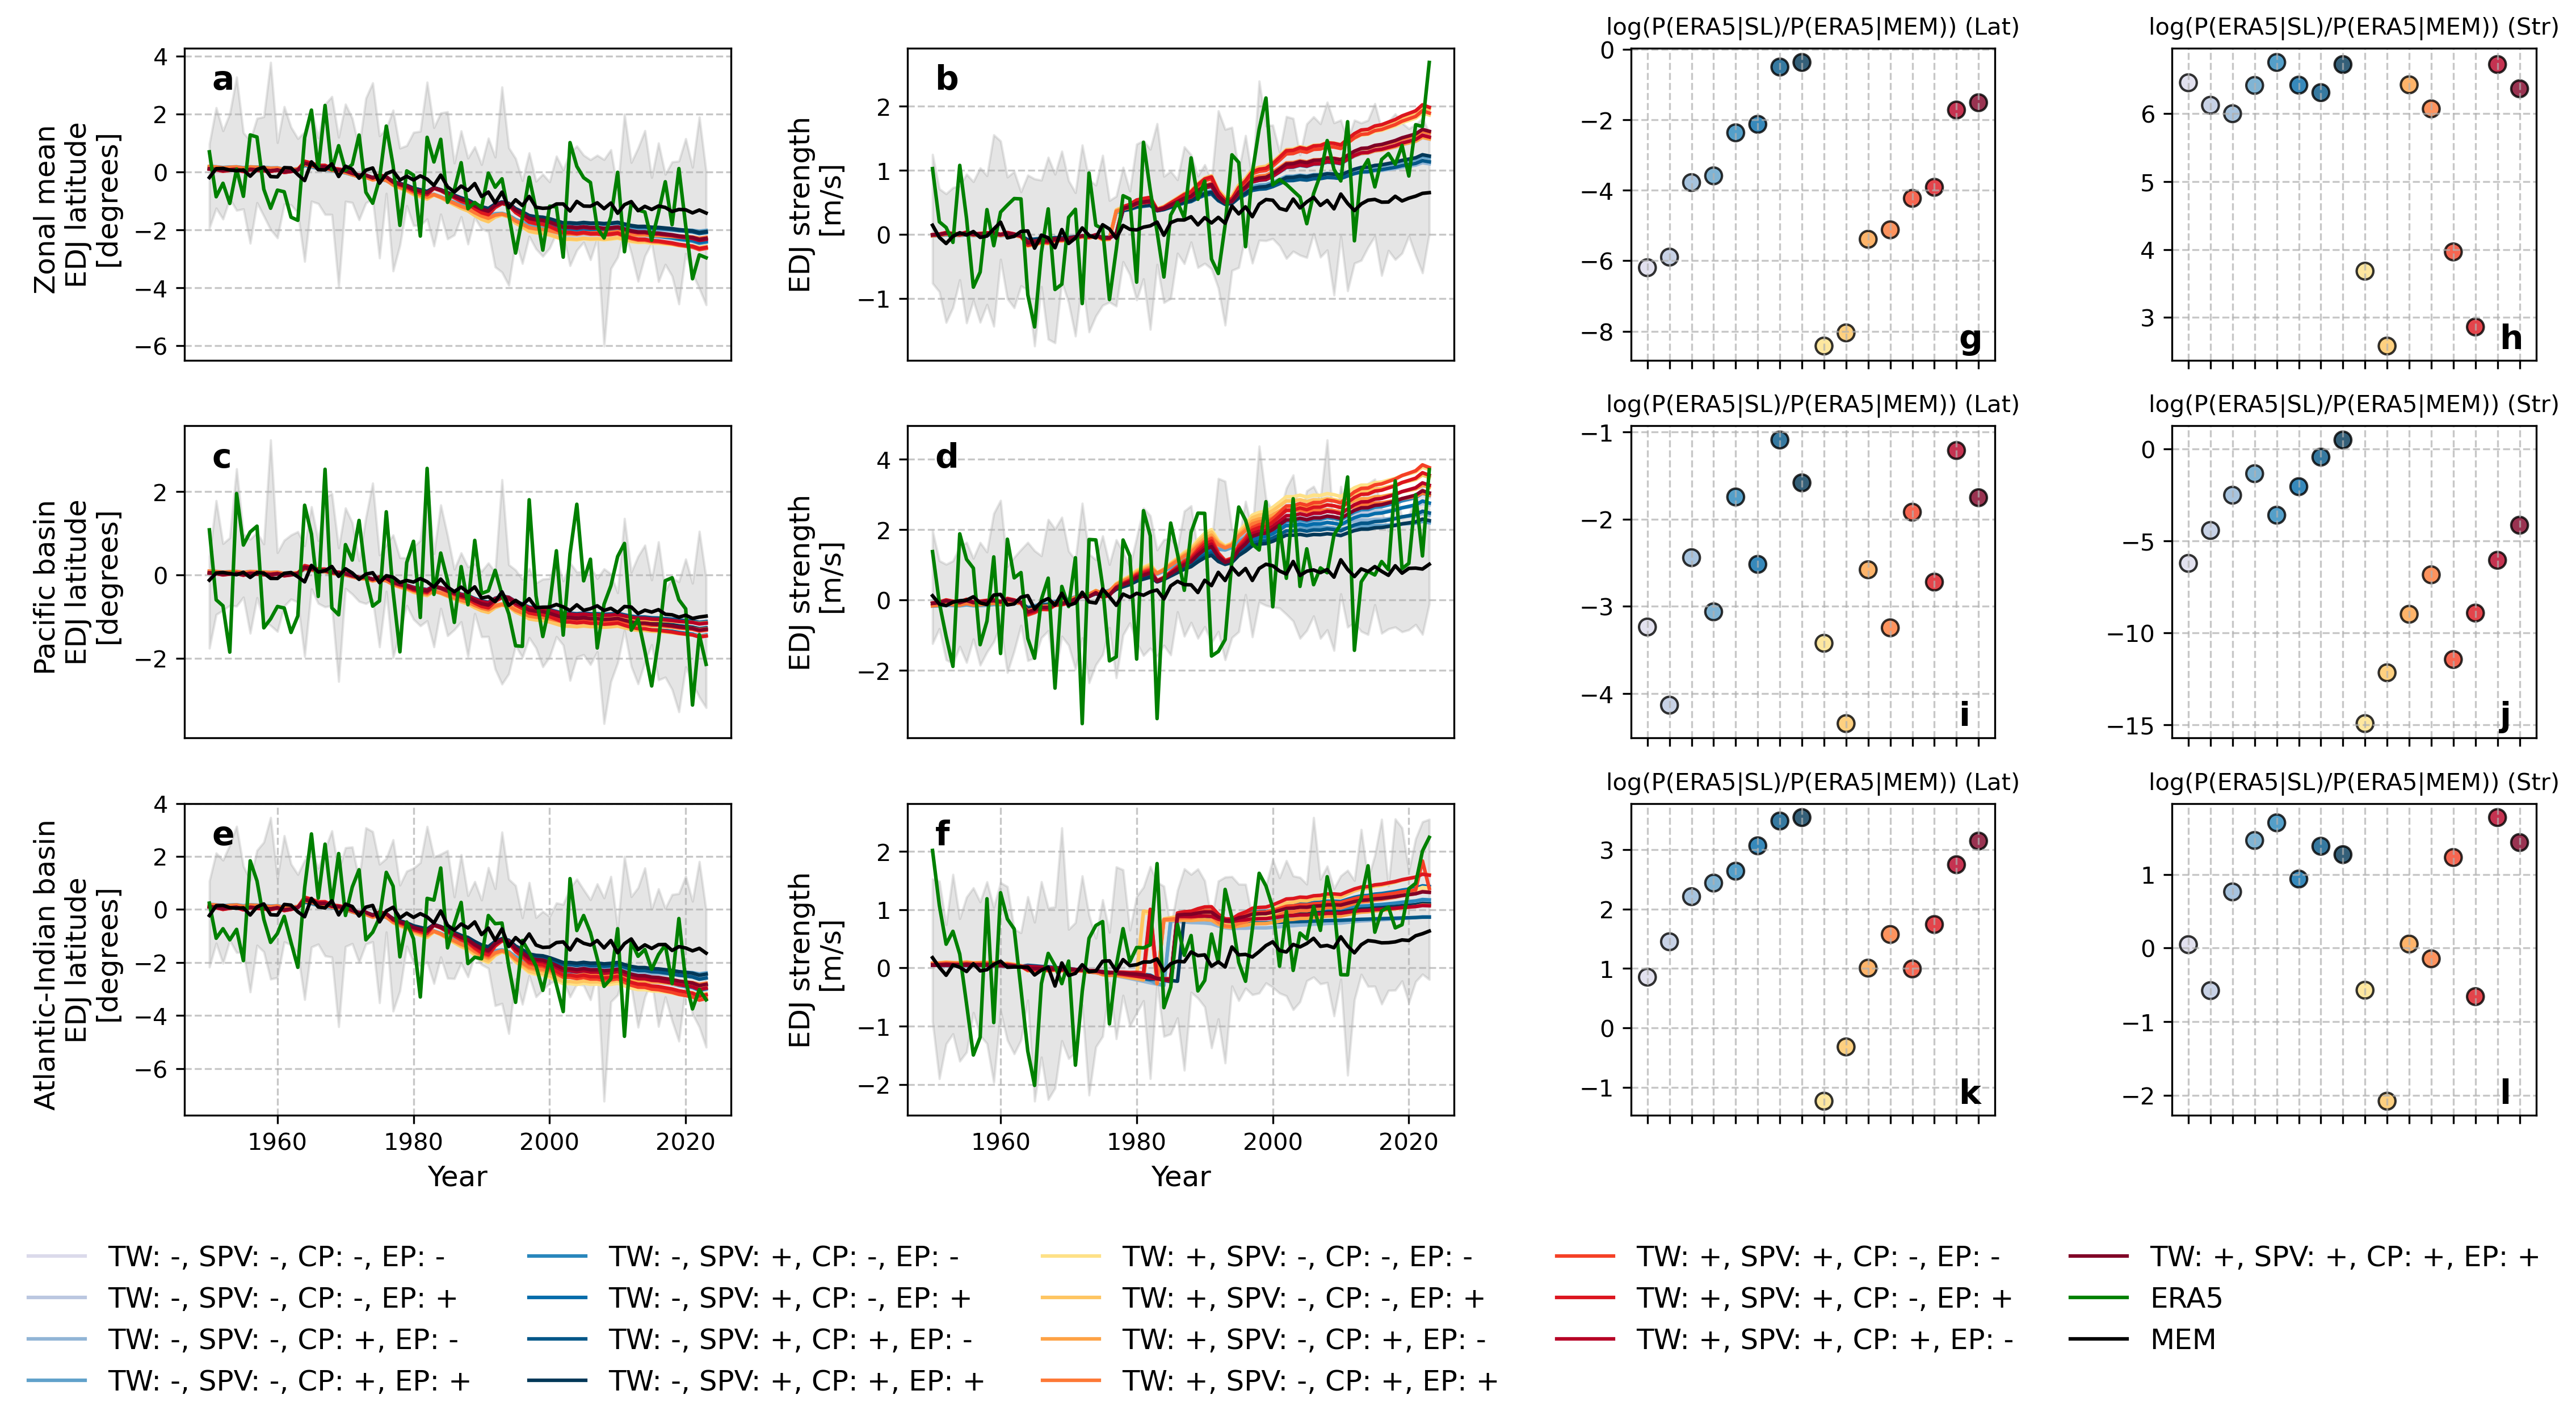

In [29]:

# Define a custom color palette (8 warm colors, 8 cool colors)
colors_warm = plt.cm.YlOrRd(np.linspace(0.2, 1, 8))
colors_cool = plt.cm.PuBu(np.linspace(0.2, 1, 8))
colors = np.vstack([colors_cool,colors_warm])

# Define the varying components
ta_sources = ["-","+"]
ua50_spv_sources = ["-","+"]
tos_cp_sources = ["-","+"]
tos_ep_sources = ["-","+"]

# Create all combinations (Cartesian product) for the varying components
combinations_names = itertools.product(ta_sources, ua50_spv_sources, tos_cp_sources, tos_ep_sources)

# Labels for subplot ticks
combination_labels = [
    f"TW: {comb[0]}, SPV: {comb[1]}, CP: {comb[2]}, EP: {comb[3]}"
    for comb in combinations_names
]

# Figure layout
fig = plt.figure(figsize=(15, 8), dpi=300)
gs = gridspec.GridSpec(3, 4, width_ratios=[3, 3, 2, 2])  # Wider layout for scatterplots

# Subplot labels and y-axis labels
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
subplot_labels_scatter = ['g','h','i','j','k','l']
y_labels = [
    'Zonal mean \n EDJ latitude \n [degrees]',
    '\n EDJ strength \n [m/s]',
    'Pacific basin \n EDJ latitude \n [degrees]',
    ' \n EDJ strength \n [m/s]',
    'Atlantic-Indian basin \n EDJ latitude \n [degrees]',
    '\n EDJ strength \n [m/s]'
]


# Prepare BF lists for scatterplots
BF_lists = [[] for _ in range(6)]  # One for each metric

# Initialize a list to store legend handles for a combined legend
legend_handles = []

# Plotting line and scatter subplots
for i in range(6):
    # Left-side line plot
    ax_line = fig.add_subplot(gs[i // 2, i % 2])
    
    # Plot observed data and confidence intervals
    ax_line.fill_between(
        np.arange(0, 74),
    data_std[i][0][:74],
    data_std[i][1][:74],
        color='grey', alpha=0.2, label='CMIP spread'
    )

    # Plot reconstructions
    for idx, recon in enumerate(stories_anom[i]):
        recon_line = ax_line.plot(
            anom(recon[:74]), color=colors[idx], label=combination_labels[idx]
        )
        BF = bayes_factor_RD(anom(era5[i][10:]), anom(recon[:74]), data[i][:74])
        BF_lists[i].append(BF)

        # Add to legend handles only once
        if i == 0:
            legend_handles.extend([*recon_line])

    line_era5 = ax_line.plot(anom(era5[i][10:]), color='green', label='ERA5')
    line_mem = ax_line.plot(data[i][:74], color='k', label='MEM')
    if i == 0:
        legend_handles.extend([line_era5[0], line_mem[0]])

    # Formatting for line plots
    ax_line.set_ylabel(y_labels[i], fontsize=12)
    
    # Only add x-labels for the bottom row
    if i >= 4:  # Only add x-labels for the last row
        ax_line.set_xlabel("Year", fontsize=12)
        ax_line.set_xticks(np.arange(10,90,20))
        ax_line.set_xticklabels(np.arange(1960,2023,20))
    else:
        ax_line.set_xticks([])  # Hide x-ticks for top and middle rows
        ax_line.grid(True, linestyle='--', alpha=0.7)

    ax_line.text(0.05, 0.95, subplot_labels[i], transform=ax_line.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax_line.grid(True, linestyle='--', alpha=0.7)
    

    # Right-side scatterplot
    ax_scatter = fig.add_subplot(gs[i // 2, 2 + i % 2])
    ax_scatter.scatter(
        np.arange(len(BF_lists[i])),
        np.log(BF_lists[i]),
        c=colors[:len(BF_lists[i])],
        s=50, edgecolors='black', alpha=0.8
    )
    ax_scatter.set_xticks(np.arange(len(BF_lists[i])))
    
    # Hide x-ticks in the top and middle rows (i < 4), and show in the bottom row (i >= 4)
    ax_scatter.set_xticklabels([])  # Hide x-ticks for top and middle rows
    # else:
    #     ax_scatter.set_xticklabels(
    #         combination_labels, rotation=90, fontsize=10, ha='right'
    #     )
    
    ax_scatter.set_title(f"log(P(ERA5|SL)/P(ERA5|MEM)) ({'Lat' if i % 2 == 0 else 'Str'})", fontsize=10)
    
    # Set gridlines manually
    ax_scatter.grid(True, linestyle='--', alpha=0.7)  # Keep vertical gridlines
    ax_scatter.text(0.90, 0.12, subplot_labels_scatter[i], transform=ax_scatter.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add a single shared legend below the figure
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=5,
    fontsize=12,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  # Below the figure
)

# Adjust layout and display
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Add space for the legend at the bottom
plt.show()

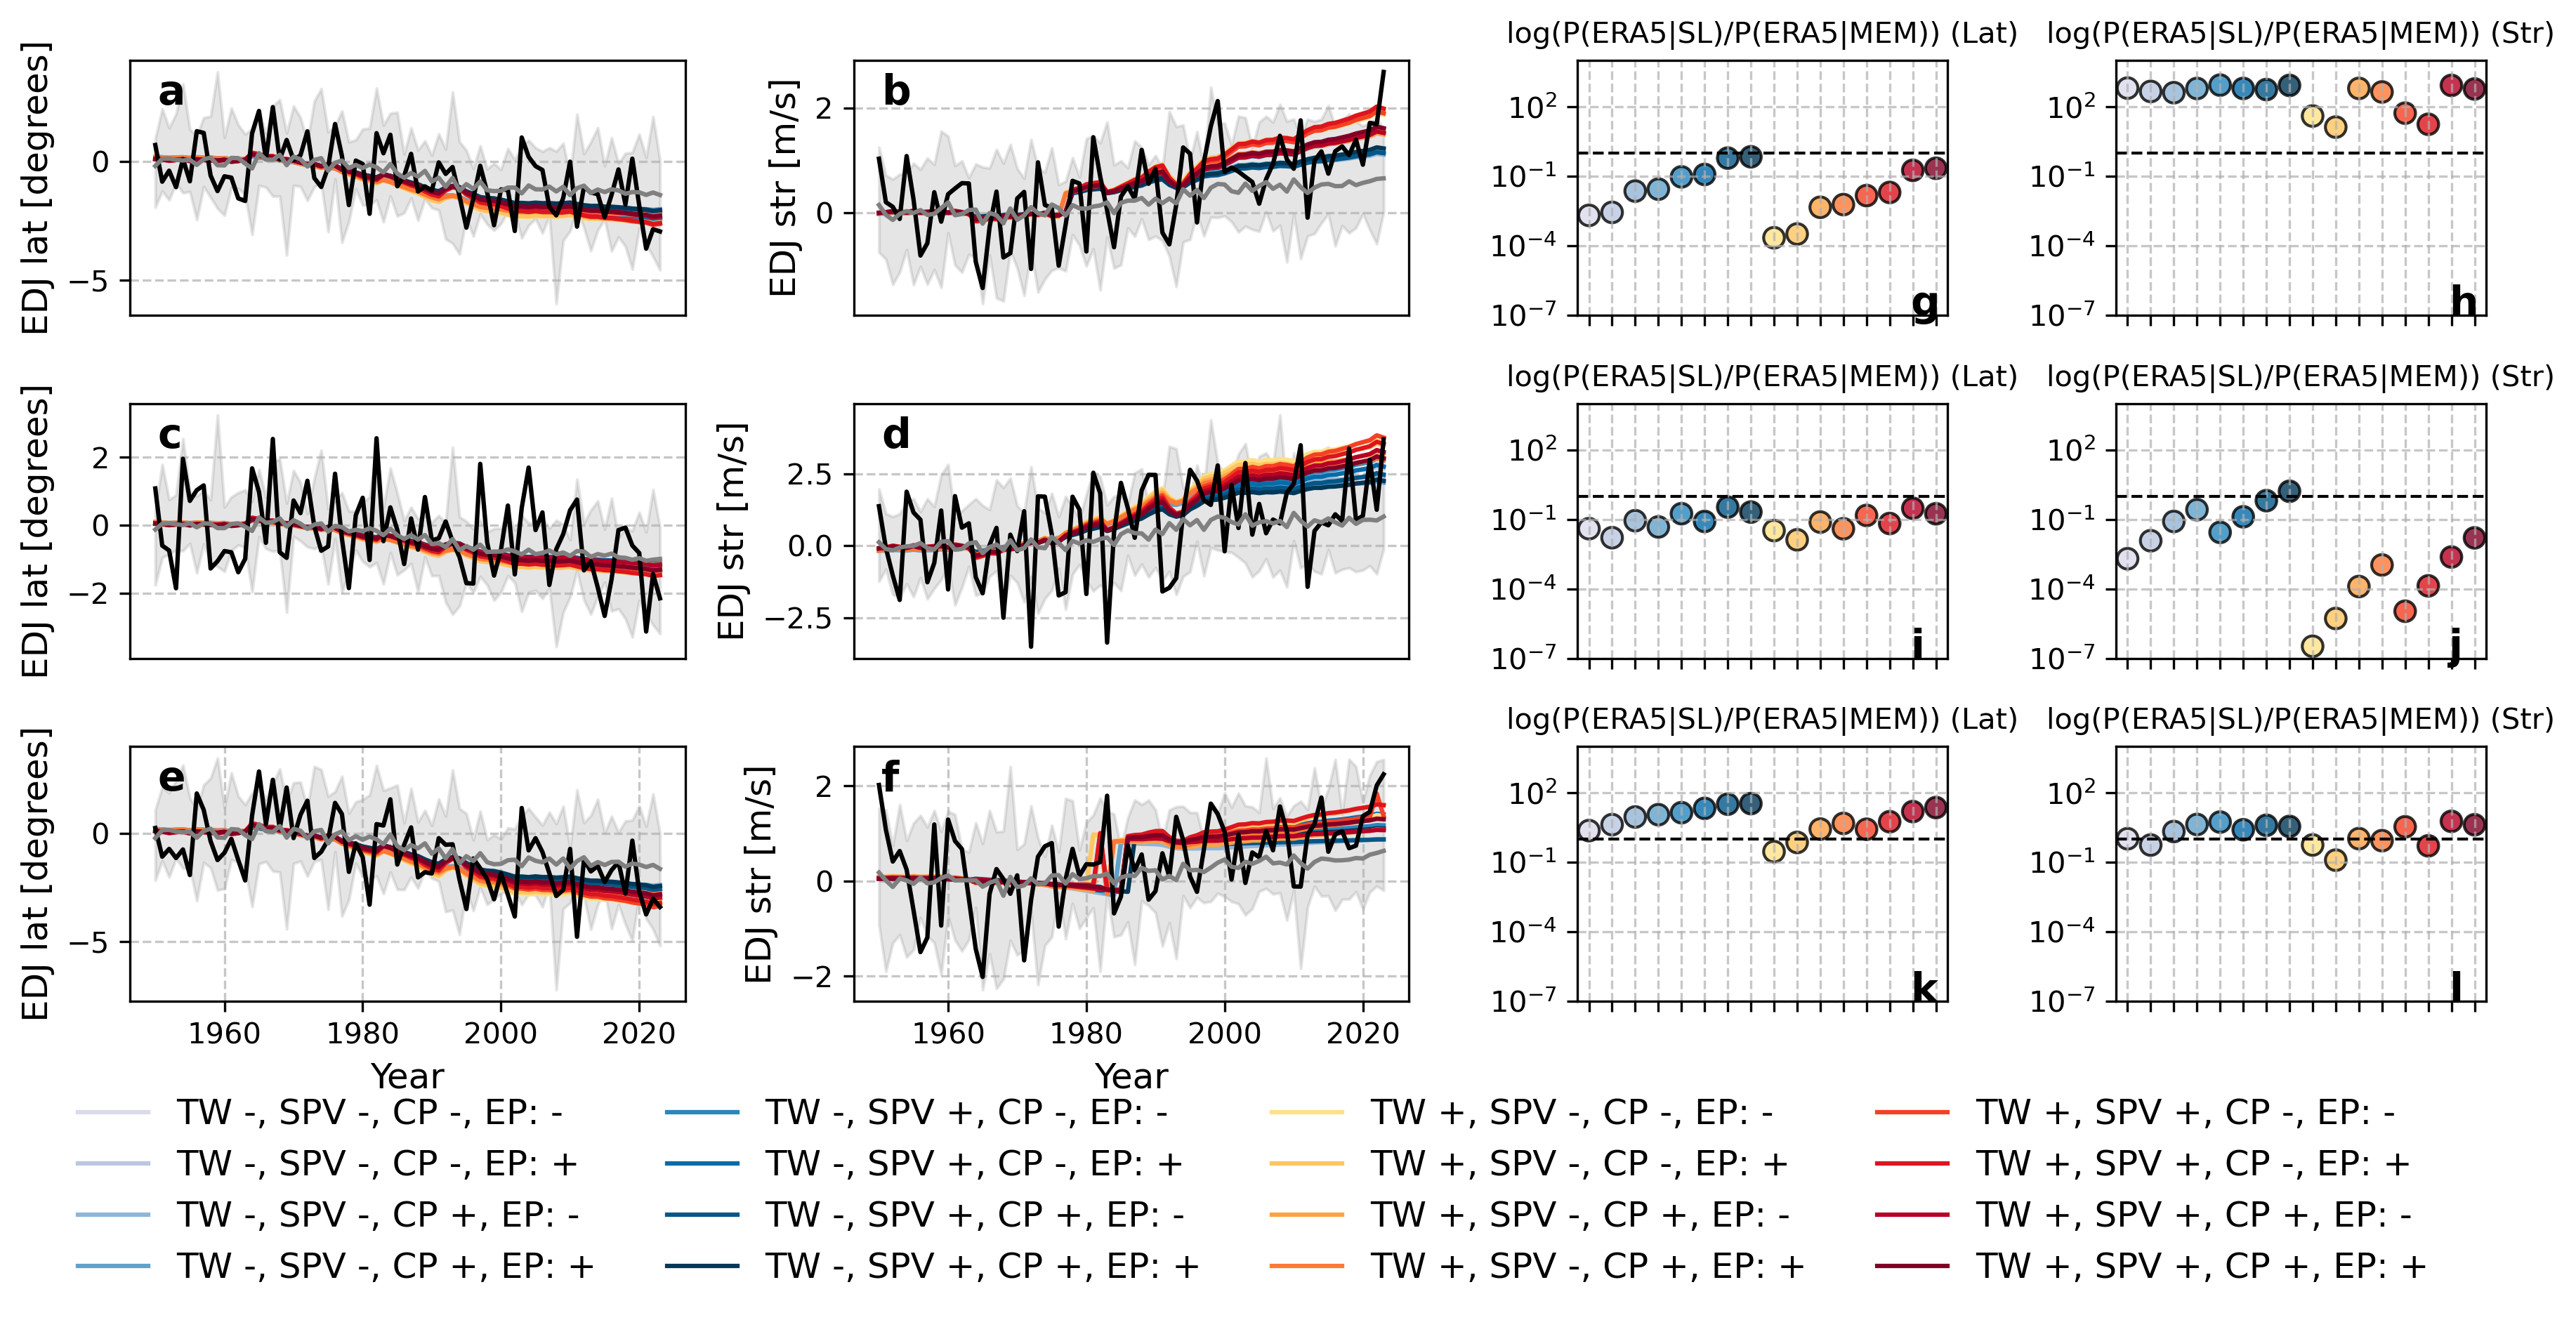

In [55]:

# Define a custom color palette (8 warm colors, 8 cool colors)
colors_warm = plt.cm.YlOrRd(np.linspace(0.2, 1, 8))
colors_cool = plt.cm.PuBu(np.linspace(0.2, 1, 8))
colors = np.vstack([colors_cool,colors_warm])

# Define the varying components
ta_sources = ["-","+"]
ua50_spv_sources = ["-","+"]
tos_cp_sources = ["-","+"]
tos_ep_sources = ["-","+"]

# Create all combinations (Cartesian product) for the varying components
combinations_names = itertools.product(ta_sources, ua50_spv_sources, tos_cp_sources, tos_ep_sources)

# Labels for subplot ticks
combination_labels = [
    f"TW {comb[0]}, SPV {comb[1]}, CP {comb[2]}, EP: {comb[3]}"
    for comb in combinations_names
]

# Figure layout
fig = plt.figure(figsize=(15, 8), dpi=300)
gs = gridspec.GridSpec(3, 4, width_ratios=[3, 3, 2, 2])  # Wider layout for scatterplots

# Subplot labels and y-axis labels
subplot_labels = ['a', 'b', 'c', 'd', 'e', 'f']
subplot_labels_scatter = ['g','h','i','j','k','l']

y_labels = [
    'Zonal mean \n EDJ latitude \n [degrees]',
    '\n EDJ strength \n [m/s]',
    'Pacific basin \n EDJ latitude \n [degrees]',
    ' \n EDJ strength \n [m/s]',
    'Atlantic-Indian basin \n EDJ latitude \n [degrees]',
    '\n EDJ strength \n [m/s]'
]


# Prepare BF lists for scatterplots
BF_lists = [[] for _ in range(6)]  # One for each metric

# Initialize a list to store legend handles for a combined legend
legend_handles = []
labels = ['CMIP6 MEM','CMIP6 spread','ERA5',' ']

 
# Plotting line and scatter subplots
for i in range(6):
    # Left-side line plot
    ax_line = fig.add_subplot(gs[i // 2, i % 2])
    
    # Plot observed data and confidence intervals
    a = ax_line.fill_between(
        np.arange(0, 74),
        data_std[i][0][:74],
        data_std[i][1][:74],
        color='grey', alpha=0.2, label='CMIP spread'
    )

    # Plot reconstructions
    for idx, recon in enumerate(stories_anom[i]):
        recon_line = ax_line.plot(
            anom(recon[:74]), color=colors[idx], label=combination_labels[idx]
        )
        BF = bayes_factor_RD(anom(era5[i][10:]), anom(recon[:74]), data[i][:74])
        BF_lists[i].append(BF)

        # Add to legend handles only once
        if i == 0:
            legend_handles.extend([*recon_line])
            labels.extend(combination_labels[idx])

    line_era5 = ax_line.plot(anom(era5[i][10:]), color='k', label='ERA5')
    line_mem = ax_line.plot(data[i][:74], color='grey', label='MEM')


    # Formatting for line plots
    ax_line.set_ylabel(y_labels1[i], fontsize=12)
    
    # Only add x-labels for the bottom row
    if i >= 4:  # Only add x-labels for the last row
        ax_line.set_xlabel("Year", fontsize=12)
        ax_line.set_xticks(np.arange(10,90,20))
        ax_line.set_xticklabels(np.arange(1960,2023,20))
    else:
        ax_line.set_xticks([])  # Hide x-ticks for top and middle rows
        ax_line.grid(True, linestyle='--', alpha=0.7)

    ax_line.text(0.05, 0.95, subplot_labels[i], transform=ax_line.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    ax_line.grid(True, linestyle='--', alpha=0.7)
    
    # Right-side scatterplot
    ax_scatter = fig.add_subplot(gs[i // 2, 2 + i % 2])
    ax_scatter.set_yscale('log')  # Set the y-axis to logarithmic scale
    ax_scatter.scatter(
        np.arange(len(BF_lists[i])),
        BF_lists[i],  # Directly use BF_lists[i], since the y-axis is already logarithmic
        c=colors[:len(BF_lists[i])],
        s=50, edgecolors='black', alpha=0.8
    )
    
    ax_scatter.set_xticks(np.arange(len(BF_lists[i])))
    ax_scatter.set_xlim(-0.5, len(BF_lists[i]) - 0.5)
    ax_scatter.set_ylim(10**-7, 10**4)  # Set y-axis limits to fit all data centered around 1
    ax_scatter.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Dashed horizontal line at y=1

    # Hide x-ticks in the top and middle rows (i < 4), and show in the bottom row (i >= 4)
    ax_scatter.set_xticklabels([])  # Hide x-ticks for top and middle rows
    # else:
    #     ax_scatter.set_xticklabels(
    #         combination_labels, rotation=90, fontsize=10, ha='right'
    #     )
    
    ax_scatter.set_title(f"log(P(ERA5|SL)/P(ERA5|MEM)) ({'Lat' if i % 2 == 0 else 'Str'})", fontsize=10)
    
    # Set gridlines manually
    ax_scatter.grid(True, which='both', linestyle='--', alpha=0.7)  # Gridlines for both major and minor ticks
    ax_scatter.text(0.90, 0.12, subplot_labels_scatter[i], transform=ax_scatter.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')



# Add a single shared legend below the figure
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=4,
    fontsize=12,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05)  # Below the figure
)

# Adjust layout and display
plt.tight_layout(rect=[0, 0.1, 1, 1])  # Add space for the legend at the bottom
plt.show()
